## <b>3 <span style='color:#B5A8D5'>|</span> Audio Preprocessing </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>3.1 |</span></b> Preprocessing Pipeline </b></p>
</div>

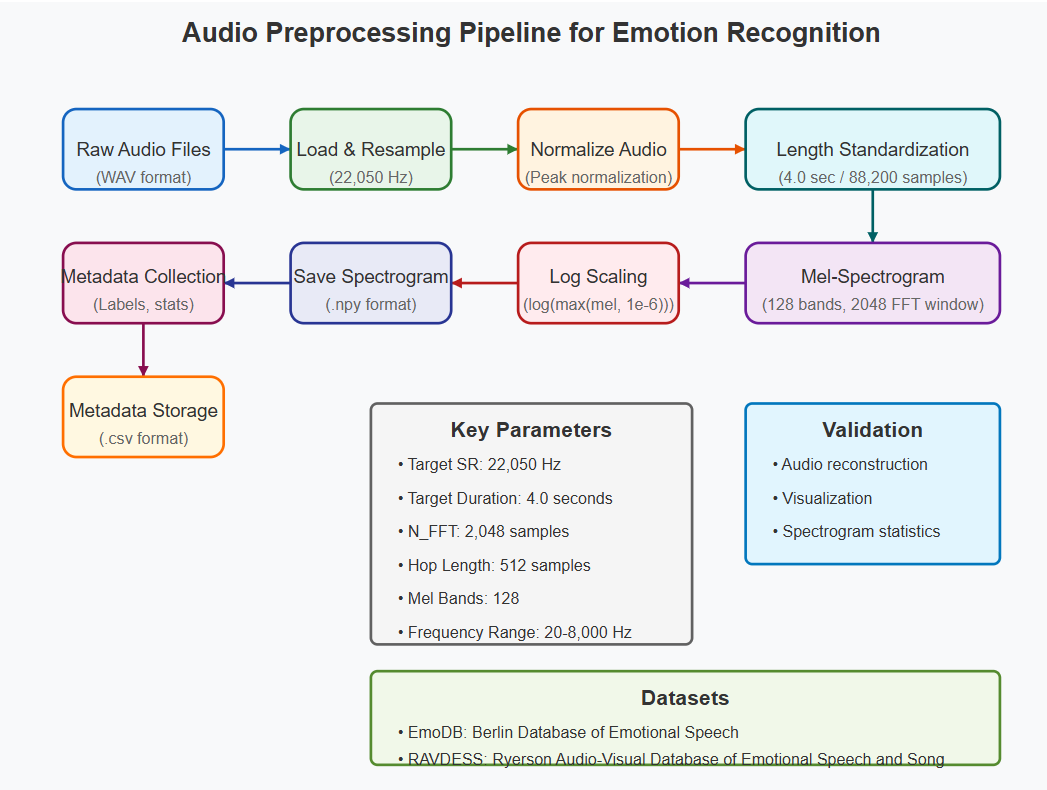

Processing emodb: 535it [00:24, 22.28it/s]


✅ Metadata for emodb saved to ..\processed\emodb_metadata.csv


Processing ravdess: 2880it [03:53, 12.34it/s]


✅ Metadata for ravdess saved to ..\processed\ravdess_metadata.csv


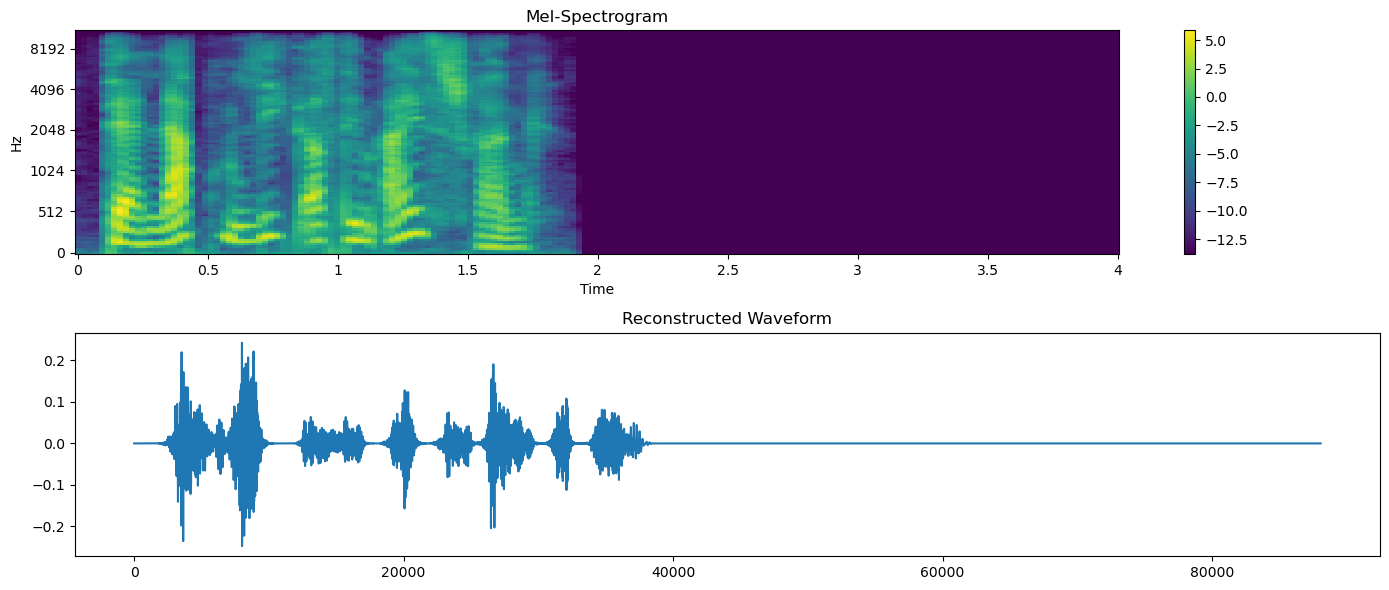

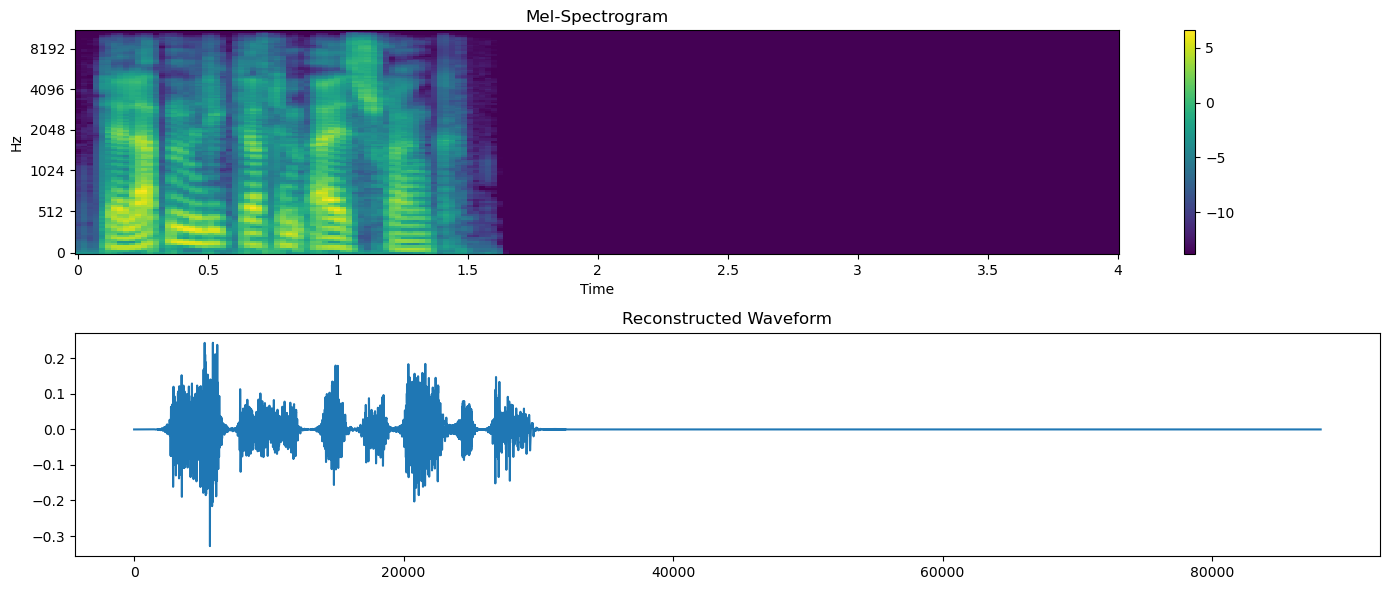

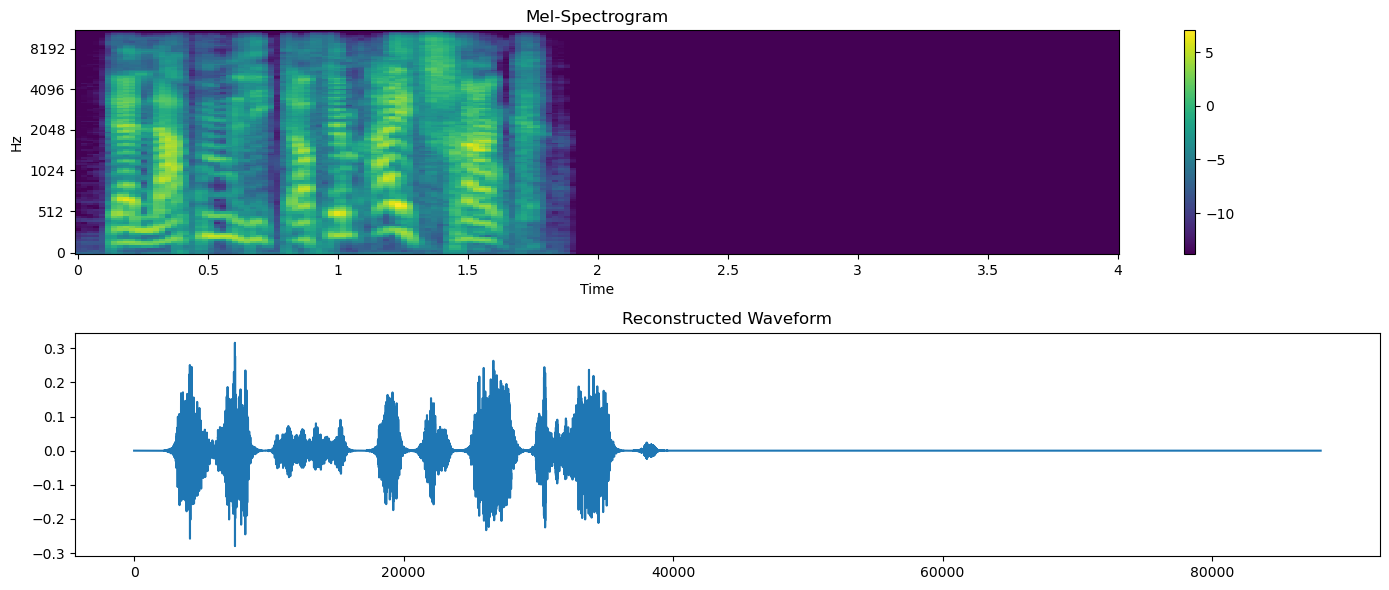

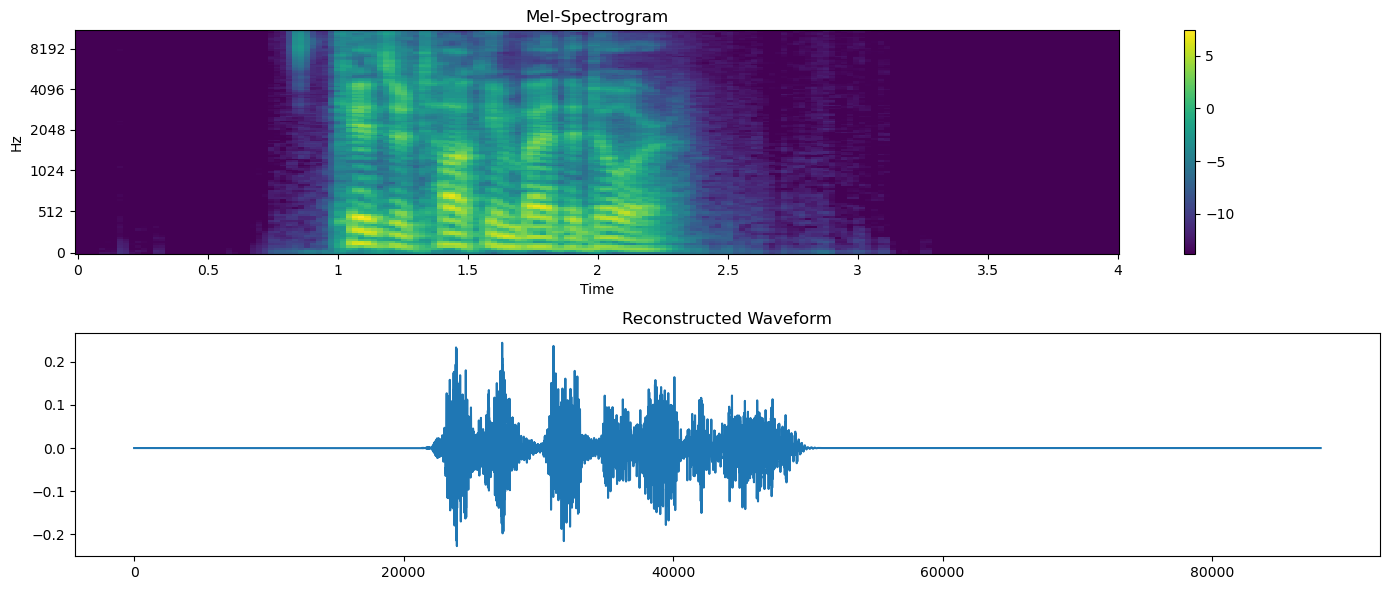

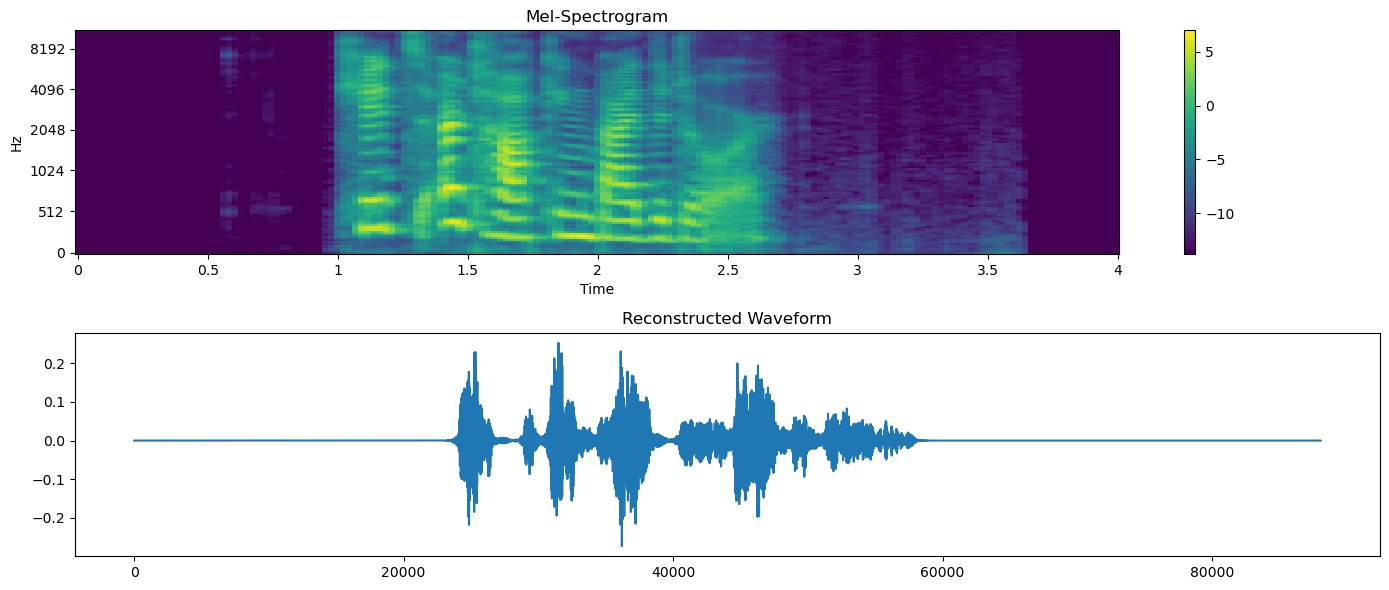

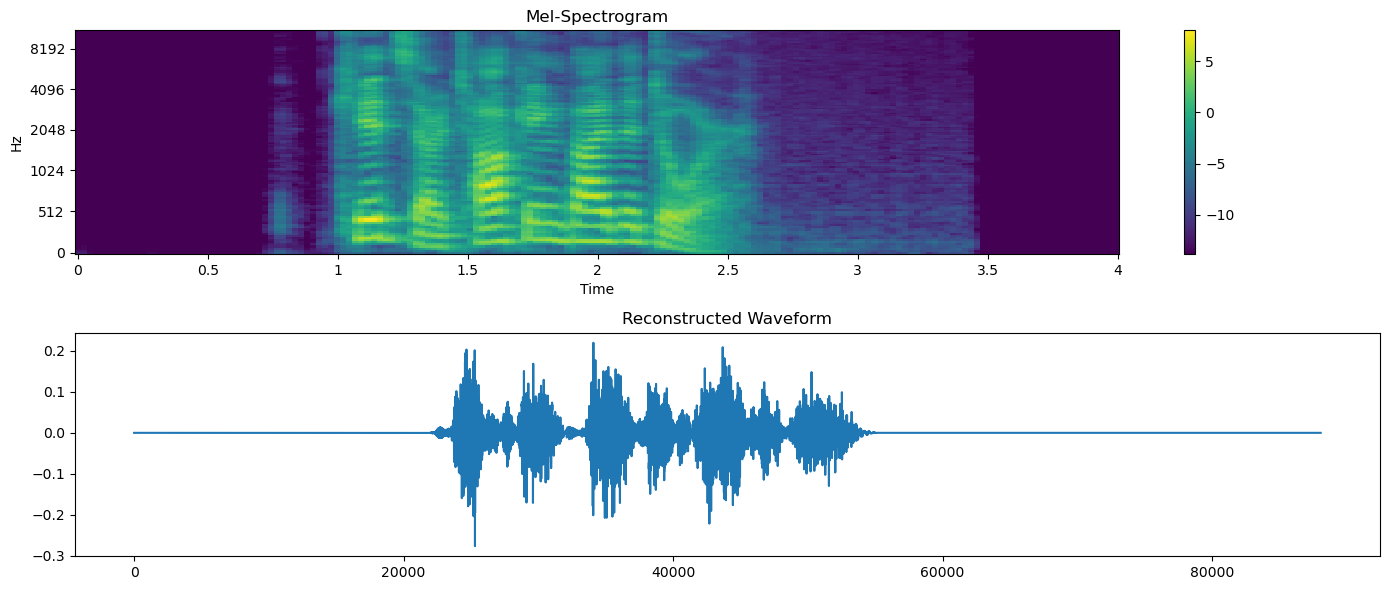

In [2]:
import numpy as np
import librosa
import os
from pathlib import Path
from scipy.signal import butter, lfilter
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# ======================================
# ⚙️ ENHANCED CONFIGURATION & PARAMETERS
# ======================================

TARGET_SR = 22050            # Standard sampling rate
TARGET_DURATION = 4.0        # Duration in seconds
TARGET_LENGTH = int(TARGET_SR * TARGET_DURATION)

# 🎛 Enhanced Mel-spectrogram settings
N_FFT = 2048                 # Window size for STFT (increased for more resolution)
HOP_LENGTH = 512             # Hop length for STFT
N_MELS = 128                 # Number of Mel bands (increased for more detail)
WIN_LENGTH = 2048            # Window length
WINDOW = 'hann'              # Window type
F_MIN = 20                   # Min frequency (reduce noise)
F_MAX = 8000                 # Max frequency (emotion content focus)

# 📁 Directories
DATA_ROOT = Path("../data")
SAVE_ROOT = Path("../processed")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

# ======================================
# 🧹 PREPROCESSING FUNCTIONS
# ======================================

def normalize_audio(y):
    """Apply peak normalization to prevent clipping."""
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """Apply a lowpass filter to smooth reconstructed audio."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

def preprocess_audio(file_path):
    """
    Enhanced preprocessing with:
    - High-resolution mel-spectrograms
    - Adaptive resizing and normalization
    Returns:
        Tuple of (mel-spectrogram, duration, mel_min, mel_max).
    """
    try:
        # Load and resample audio
        y, sr = librosa.load(file_path, sr=TARGET_SR)
        y = normalize_audio(y)

        # Ensure consistent length
        duration = len(y) / sr
        if len(y) > TARGET_LENGTH:
            center = len(y) // 2
            y = y[center - TARGET_LENGTH // 2:center + TARGET_LENGTH // 2]
        elif len(y) < TARGET_LENGTH:
            y = np.pad(y, (0, TARGET_LENGTH - len(y)))

        # Compute mel-spectrogram
        mel = librosa.feature.melspectrogram(
            y=y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH, n_mels=N_MELS, fmin=F_MIN, fmax=F_MAX, power=2.0
        )
        mel_log = np.log(np.maximum(mel, 1e-6))  # Log scaling for stability

        # Get min and max of mel-spectrogram
        mel_min = np.min(mel_log)
        mel_max = np.max(mel_log)

        return mel_log, duration, mel_min, mel_max, mel_log.shape
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None, None

# ======================================
# 🚀 PROCESSING AND METADATA GENERATION
# ======================================

def process_dataset(dataset_name):
    """
    Process dataset, save mel-spectrograms, and generate metadata.
    """
    input_dir = DATA_ROOT / dataset_name
    output_dir = SAVE_ROOT / dataset_name
    output_dir.mkdir(parents=True, exist_ok=True)

    # Metadata storage
    metadata = []

    # Label mappings for datasets
    emodb_label_map = {
        'W': 'anger', 'L': 'boredom', 'E': 'disgust',
        'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'
    }
    ravdess_label_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }

    # Process each audio file
    for file_path in tqdm(input_dir.rglob("*.wav"), desc=f"Processing {dataset_name}"):
        mel, duration, mel_min, mel_max, mel_shape = preprocess_audio(file_path)

        if mel is not None:
            # Save mel-spectrogram
            save_path = output_dir / file_path.with_suffix(".npy").name
            np.save(save_path, mel)

            # Collect metadata based on dataset
            if dataset_name.lower() == "emodb":
                code = file_path.stem[5]  # 6th character is the emotion label
                label = emodb_label_map.get(code, "unknown")

                metadata.append({
                    "file_path": str(save_path),
                    "original_file": str(file_path),
                    "duration_seconds": duration,
                    "label": label,
                    "mel_min": mel_min,
                    "mel_max": mel_max,
                    "shape": mel_shape
                })

            elif dataset_name.lower() == "ravdess":
                try:
                    parts = file_path.stem.split("-")
                    emotion_id = int(parts[2])  # Emotion ID from file name
                    label = ravdess_label_map.get(emotion_id, "unknown")

                    # Extract actor ID and determine gender
                    actor_id = int(parts[6])
                    gender = "male" if actor_id % 2 == 1 else "female"

                    metadata.append({
                        "file_path": str(save_path),
                        "original_file": str(file_path),
                        "duration_seconds": duration,
                        "label": label,
                        "gender": gender,
                        "mel_min": mel_min,
                        "mel_max": mel_max,
                        "shape": mel_shape
                    })
                except Exception as e:
                    print(f"Error extracting metadata for RAVDESS file {file_path}: {e}")

    # Save metadata as CSV
    metadata_df = pd.DataFrame(metadata)
    metadata_csv_path = SAVE_ROOT / f"{dataset_name}_metadata.csv"
    metadata_df.to_csv(metadata_csv_path, index=False)
    print(f"✅ Metadata for {dataset_name} saved to {metadata_csv_path}")

# ======================================
# 🚀 VALIDATION PIPELINE
# ======================================

def validate_preprocessing(dataset_name, num_samples=3):
    """
    Validate preprocessing by reconstructing audio and comparing.
    """
    input_dir = SAVE_ROOT / dataset_name
    for i, file_path in enumerate(input_dir.glob("*.npy")):
        if i >= num_samples:
            break

        # Load mel-spectrogram
        mel = np.load(file_path)

        # Reconstruct audio
        reconstructed_audio = librosa.feature.inverse.mel_to_audio(
            mel, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH, window=WINDOW, fmin=F_MIN, fmax=F_MAX, power=2.0
        )

        # Plot original vs reconstructed
        plt.figure(figsize=(14, 6))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(mel, sr=TARGET_SR, x_axis="time", y_axis="mel", cmap="viridis")
        plt.title("Mel-Spectrogram")
        plt.colorbar()

        plt.subplot(2, 1, 2)
        plt.plot(reconstructed_audio)
        plt.title("Reconstructed Waveform")
        plt.tight_layout()
        plt.show()

# ======================================
# 🚀 RUN THE PIPELINE
# ======================================

if __name__ == "__main__":
    # Process datasets and generate metadata
    process_dataset("emodb")
    process_dataset("ravdess")

    # Validate results
    validate_preprocessing("emodb", num_samples=3)
    validate_preprocessing("ravdess", num_samples=3)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>3.2 |</span></b> Original audio VS Prerpocessed audio  </b></p>
</div>

C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


🎧 Original Audio:


🎧 Preprocessed Audio (Reconstructed):


C:\Users\dhouh\AppData\Local\Temp\ipykernel_19160\2495485052.py:108: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dhouh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


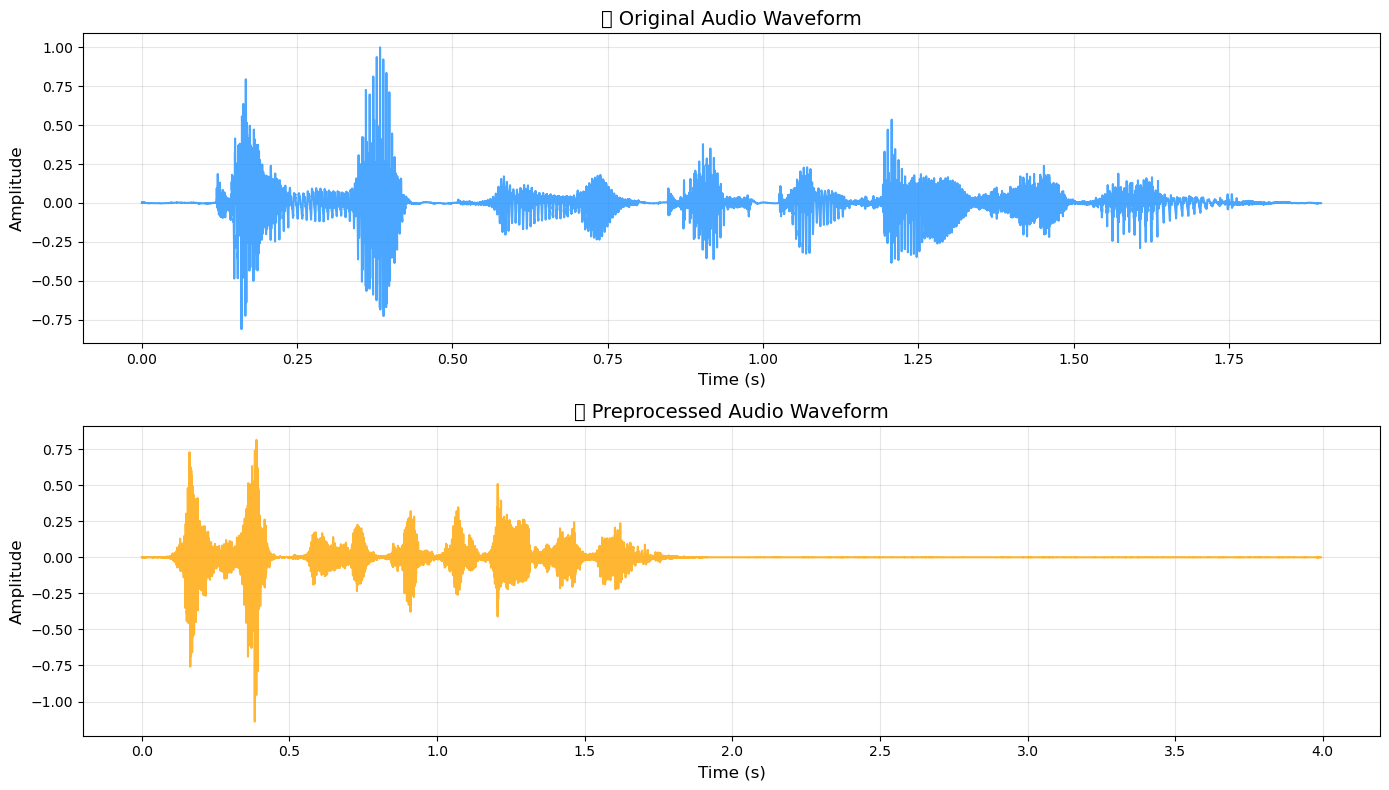

C:\Users\dhouh\AppData\Local\Temp\ipykernel_19160\2495485052.py:117: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dhouh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


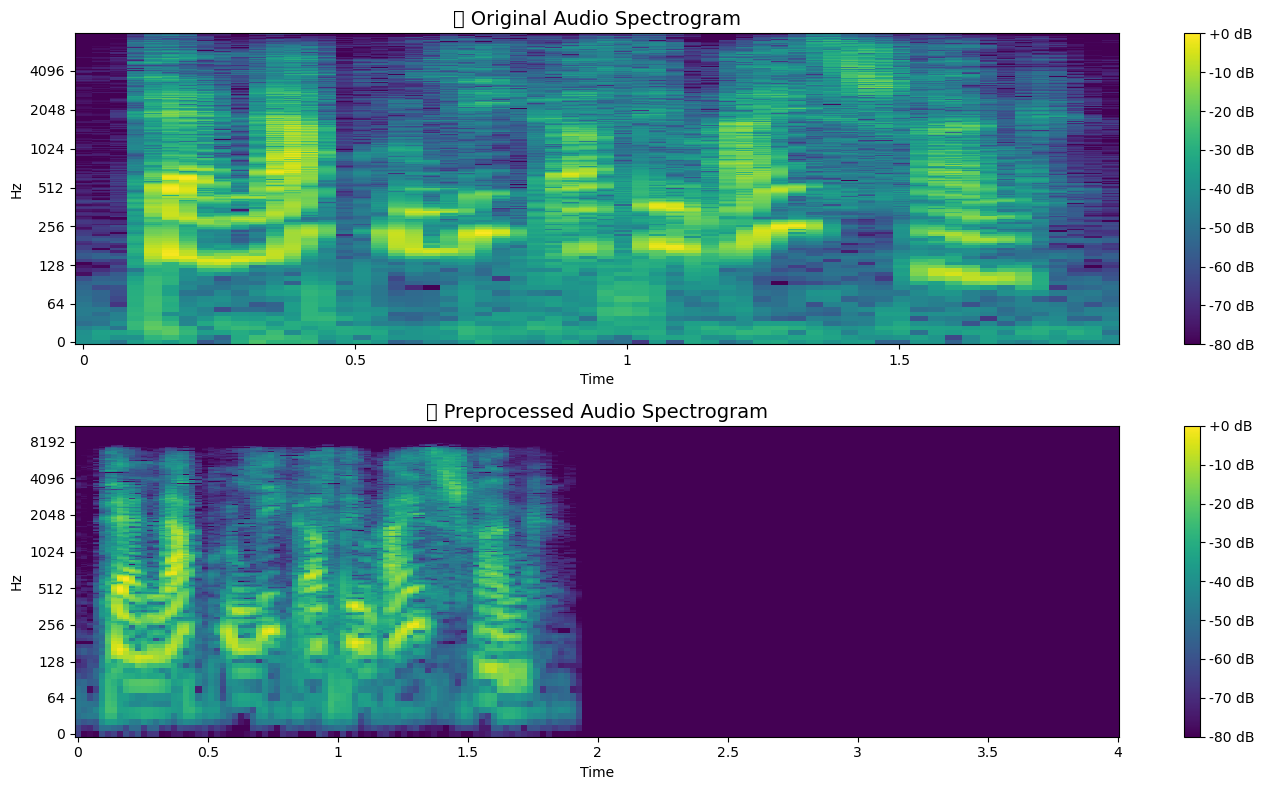

In [1]:
# 📦 Required Imports
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from pathlib import Path
import matplotlib

# ✅ Set global matplotlib options
matplotlib.rcParams.update({'figure.autolayout': True})

# 🎯 Utility Function
def display_audio_comparison(original_file_path, preprocessed_file_path, title="Sample Audio Comparison"):
    """
    Compare the original and preprocessed audio by displaying:
    1. Embedded audio players for both (original and reconstructed).
    2. Waveforms for both.
    3. Spectrograms for both.

    Parameters:
    -----------
    original_file_path : str or Path
        Path to the original audio file.

    preprocessed_file_path : str or Path
        Path to the preprocessed .npy file (mel-spectrogram).

    title : str, optional
        Custom title for the plots and display. Default is "Sample Audio Comparison".
    """
    def load_original_audio(file_path):
        try:
            y, sr = librosa.load(file_path, sr=None)  # sr=None to preserve original sampling rate
            return y, sr
        except Exception as e:
            print(f"❌ Error loading original audio file {file_path}: {e}")
            return None, None

    def load_preprocessed_audio(file_path):
        try:
            # Load mel-spectrogram from .npy file
            mel_spectrogram = np.load(file_path)

            # Reverse log scaling
            mel_spectrogram = np.exp(mel_spectrogram)

            # Reconstruct audio from mel-spectrogram
            reconstructed_audio = librosa.feature.inverse.mel_to_audio(
                mel_spectrogram,
                sr=22050,
                n_fft=2048,  # As per enhanced preprocessing
                hop_length=512,
                win_length=2048,
                window='hann',
                fmin=20,
                fmax=8000,
                power=2.0,
                n_iter=64  # Increased iterations for better quality
            )
            return reconstructed_audio, 22050
        except Exception as e:
            print(f"❌ Error loading preprocessed audio file {file_path}: {e}")
            return None, None

    def plot_waveform(y, sr, title, color='dodgerblue'):
        duration = len(y) / sr
        time = np.linspace(0, duration, len(y))
        plt.plot(time, y, alpha=0.8, color=color)
        plt.title(title, fontsize=14)
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(alpha=0.3)

    def plot_spectrogram(y, sr, title):
        D = librosa.stft(y, n_fft=2048, hop_length=512, win_length=2048)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(
            S_db,
            sr=sr,
            x_axis='time',
            y_axis='log',
            cmap='viridis'
        )
        plt.colorbar(img, format='%+2.0f dB')
        plt.title(title, fontsize=14)

    # Load original and preprocessed audio
    original_audio, original_sr = load_original_audio(original_file_path)
    preprocessed_audio, preprocessed_sr = load_preprocessed_audio(preprocessed_file_path)

    if original_audio is None or preprocessed_audio is None:
        return

    # Display audio players
    print("🎧 Original Audio:")
    ipd.display(ipd.Audio(original_audio, rate=original_sr))

    print("🎧 Preprocessed Audio (Reconstructed):")
    ipd.display(ipd.Audio(preprocessed_audio, rate=preprocessed_sr))

    # Plot waveforms
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plot_waveform(original_audio, original_sr, "🔊 Original Audio Waveform", color='dodgerblue')
    plt.subplot(2, 1, 2)
    plot_waveform(preprocessed_audio, preprocessed_sr, "🔊 Preprocessed Audio Waveform", color='orange')
    plt.tight_layout()
    plt.show()

    # Plot spectrograms
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plot_spectrogram(original_audio, original_sr, "🎼 Original Audio Spectrogram")
    plt.subplot(2, 1, 2)
    plot_spectrogram(preprocessed_audio, preprocessed_sr, "🎼 Preprocessed Audio Spectrogram")
    plt.tight_layout()
    plt.show()


# Example Usage:
# Paths to the original and preprocessed audio (update paths as needed)
original_audio_path = Path("../data/emodb/03a01Fa.wav")  # Replace with actual path to an original file
preprocessed_audio_path = Path("../processed/emodb/03a01Fa.npy")  # Replace with actual path to a preprocessed .npy file

# Call the function to display and compare
display_audio_comparison(original_audio_path, preprocessed_audio_path, title="EmoDB Audio Comparison")

In [2]:
import pandas as pd
from pathlib import Path

# Paths to the processed feature CSVs
emodb_csv = Path("../processed/emodb_metadata.csv")
ravdess_csv = Path("../processed/ravdess_metadata.csv")

# Load CSVs
df_emodb = pd.read_csv(emodb_csv)
df_ravdess = pd.read_csv(ravdess_csv)

# Styling function for Pandas DataFrame
def style_table(df):
    return df.style.set_properties(**{
        'background-color': 'lightblue',  # Background color for the entire table
        'color': 'black',  # Text color
        'border': '1px solid black',  # Border for table cells
        'font-size': '12pt',  # Font size
        'font-family': 'Arial'  # Font family
    }).set_table_styles([
        {'selector': 'thead th',  # Apply styles to header
         'props': [('background-color', 'darkblue'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'thead', 'props': [('border', '2px solid black')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#e6e6e6')]}  # Hover effect
    ])

# Display styled tables for EMODB and RAVDESS
print("📄 EMODB metadata (head):")
display(style_table(df_emodb.head()))

print("\n📄 RAVDESS metadata (head):")
display(style_table(df_ravdess.head()))


📄 EMODB metadata (head):


,file_path,original_file,duration_seconds,label,mel_min,mel_max,shape
0,..\processed\emodb\03a01Fa.npy,..\data\emodb\03a01Fa.wav,1.898277,happiness,-13.815511,5.862330,"(128, 173)"
1,..\processed\emodb\03a01Nc.npy,..\data\emodb\03a01Nc.wav,1.611293,neutral,-13.815511,6.584102,"(128, 173)"
2,..\processed\emodb\03a01Wa.npy,..\data\emodb\03a01Wa.wav,1.877823,anger,-13.815511,7.024076,"(128, 173)"
3,..\processed\emodb\03a02Fc.npy,..\data\emodb\03a02Fc.wav,2.006259,happiness,-13.815511,7.284846,"(128, 173)"
4,..\processed\emodb\03a02Nc.npy,..\data\emodb\03a02Nc.wav,1.439819,neutral,-13.815511,6.830539,"(128, 173)"



📄 RAVDESS metadata (head):


,file_path,original_file,duration_seconds,label,gender,mel_min,mel_max,shape
0,..\processed\ravdess\03-01-01-01-01-01-01.npy,..\data\ravdess\Actor_01\03-01-01-01-01-01-01.wav,3.303311,neutral,male,-13.815511,7.416340,"(128, 173)"
1,..\processed\ravdess\03-01-01-01-01-02-01.npy,..\data\ravdess\Actor_01\03-01-01-01-01-02-01.wav,3.336689,neutral,male,-13.815511,6.967915,"(128, 173)"
2,..\processed\ravdess\03-01-01-01-02-01-01.npy,..\data\ravdess\Actor_01\03-01-01-01-02-01-01.wav,3.269932,neutral,male,-13.815511,6.916947,"(128, 173)"
3,..\processed\ravdess\03-01-01-01-02-02-01.npy,..\data\ravdess\Actor_01\03-01-01-01-02-02-01.wav,3.169841,neutral,male,-13.815511,6.728708,"(128, 173)"
4,..\processed\ravdess\03-01-02-01-01-01-01.npy,..\data\ravdess\Actor_01\03-01-02-01-01-01-01.wav,3.536871,calm,male,-13.815511,7.283346,"(128, 173)"


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>3.2 |</span></b> Creating combined metadata for both datasets   </b></p>
</div>

In [ ]:
import pandas as pd
from pathlib import Path

# Paths to metadata files
processed_dir = Path("../processed")
emodb_metadata_path = processed_dir / "emodb_metadata.csv"
ravdess_metadata_path = processed_dir / "ravdess_metadata.csv"
combined_metadata_path = processed_dir / "metadata.csv"

# Load metadata files
emodb_metadata = pd.read_csv(emodb_metadata_path)
ravdess_metadata = pd.read_csv(ravdess_metadata_path)

# Add a "dataset" column to differentiate between datasets
emodb_metadata['dataset'] = 'emodb'
ravdess_metadata['dataset'] = 'ravdess'

# Combine metadata files
combined_metadata = pd.concat([emodb_metadata, ravdess_metadata], ignore_index=True)

# Save combined metadata
combined_metadata.to_csv(combined_metadata_path, index=False)

print(f"Combined metadata saved to {combined_metadata_path}")


## 📊 **Comparative Analysis: Preprocessing Pipeline vs. Research Paper Methodology**

This comparison contrasts the implemented preprocessing pipeline with the methodology outlined in the research paper *"A Generation of Enhanced Data by Variational Autoencoders and Diffusion Modeling"* by **Kim and Lee (2024)**.

---

### 🧾 **Comparison Table**

| 🧩 **Aspect**                | 📄 **Research Paper Methodology**                                                           | 🛠️ **Provided Code**                                                                | ✅ **Alignment**                                                                                       |
| ---------------------------- | ------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------- |
|  **Dataset Sampling Rate**   | Resampled EmoDB (16 kHz) and RAVDESS (48 kHz) to **22,025 Hz**.                             | Resamples to **22,050 Hz** (`TARGET_SR = 22050`).                                    | ✔️ **Aligned**: Minor difference (22,050 vs 22,025 Hz) — negligible impact.                           |
|  **Audio Length Adjustment** | Pads all samples to **10 seconds**.                                                         | Pads or trims audio to **4 seconds** (`TARGET_DURATION = 4.0`).                      | ⚠️ **Partially Aligned**: Shorter duration may reduce emotional context.                              |
|  **Mel-Spectrogram Parameters** | STFT with **hop length = 256**, **window size = 1024**.                                     | Uses `HOP_LENGTH = 512`, `WIN_LENGTH = 2048`, `N_FFT = 2048`.                        | 🔄 **Aligned**: Higher resolution in code adds detail but diverges slightly.                          |
|  **Frequency Range**         | Uses full spectrum of mel-spectrograms.                                                     | Restricts to **20 Hz–8 kHz** (`F_MIN = 20`, `F_MAX = 8000`).                         | ✔️ **Aligned**: Focused on emotion-relevant frequencies — consistent with paper’s goals.              |
|  **Normalization**           | Applies **Z-score normalization** on mel-spectrograms.                                      | Uses **peak normalization** + **log scaling**.                                       | ⚠️ **Partially Aligned**: Different approach, but log scaling aids stability.                         |
|  **Mel-Spectrogram Features** | Uses STFT-based mel-spectrograms with Z-score normalization.                                | Extracts **128-band mel-spectrograms** with log scaling.                             | ✔️ **Aligned**: Uses mel-spectrograms as primary feature, with slight param differences.              |
|  **Preprocessing Technique** | Avoids FFT to preserve temporal dynamics; uses STFT.                                        | Applies **STFT with Hann window**.                                                   | ✔️ **Aligned**: Both emphasize STFT for temporal retention.                                           |
|  **Metadata Generation**   | Labels and groups emotional data per dataset.                                               | Generates metadata with mappings for EmoDB and RAVDESS.                              | ✔️ **Aligned**: Follows the paper’s labeling structure.                                               |
|  **Validation Method**     | Uses **emotion recognition models** and confusion matrices to evaluate spectrogram quality. | Visualizes audio reconstructions from spectrograms (no classifier-based validation). | ⚠️ **Partially Aligned**: Lacks model-based validation but includes reconstruction and visualization. |
|  **Output Format**         | Outputs **mel-spectrograms** for downstream tasks.                                          | Saves as `.npy` files and logs metadata in CSV.                                      | ✔️ **Aligned**: Output format supports further analysis and modeling.                                 |

---

### 🧪 **Summary**

#### ✅ **Strengths**

*  Uses **mel-spectrograms** effectively for emotion representation.
*  Implements consistent **resampling and feature extraction**.
*  Generates clear **metadata** and structured outputs.
*  Enhances preprocessing through higher resolution and **frequency noise reduction**.

#### ⚠️ **Deviations**

*  **Audio trimmed to 4 seconds** instead of the paper’s 10 seconds.
*  **Peak normalization** used instead of Z-score.
*  **Validation** lacks classifier-based emotion analysis.


